<a href="https://colab.research.google.com/github/Jgallear/CSSP_brazil_23_24/blob/main/plot_best_model_results_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# plot map of model performance,
# plot model performance against ENSO mode
# plot model performance for important months
!pip install cartopy

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from sklearn.inspection import PartialDependenceDisplay
from shapely.geometry import Point
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
#from rasterio import CRS
from shapely.geometry import mapping
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import Ridge
import functools
import pickle
import cartopy.feature as cf
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import tensorflow as tf
import itertools
import seaborn as sns

In [ ]:
GBM_res = pd.read_csv('/content/drive/MyDrive/model_outs/GBM_out_df.csv')
#GBM_res = pd.read_csv('/content/drive/MyDrive/model_outs/GBM_out_df_optimized.csv')
print(GBM_res.columns)

Index(['lat', 'lon', 'month', 'year', 'prediction', 'testy'], dtype='object')


In [ ]:
print(GBM_res)

           lat     lon  month  year  prediction      testy
0      -32.125 -53.375      1  2020   52.728965  62.826713
1      -32.125 -53.375      2  2020   56.842481  56.945423
2      -32.125 -53.375      3  2020   49.303301  39.100269
3      -32.125 -53.375      4  2020   38.548451  28.971330
4      -32.125 -53.375      5  2020   39.277928  31.129586
...        ...     ...    ...   ...         ...        ...
327842  -0.875 -47.625      8  2005   49.981668  44.921780
327843  -0.875 -47.625      9  2005   43.396509  35.035883
327844  -0.875 -47.625     10  2005   37.141274  35.797030
327845  -0.875 -47.625     11  2005   38.814913  38.391717
327846  -0.875 -47.625     12  2005   37.974347  45.080830

[327847 rows x 6 columns]


In [ ]:
def groupby_gc(df):
  df_list=[]
  for index,df in df.groupby(['lat','lon']):
    df_list.append(df)
  return df_list

In [ ]:
# produce maps of correlation between VHI and each of the df_vars variables
def per_gc_metrics(df,var='VHI'):
  m1_df_anom_gc_list = groupby_gc(df)
  lat_list=[]
  lon_list=[]
  _ccoefs=[]
  _r2=[]
  _mae=[]
  for i in range(len(m1_df_anom_gc_list)):
    # get average vhi and plot
    _ccoefs.append(pearsonr(m1_df_anom_gc_list[i]['testy'],m1_df_anom_gc_list[i]['prediction'])[0])
    _r2.append(r2_score(m1_df_anom_gc_list[i]['testy'],m1_df_anom_gc_list[i]['prediction']))
    _mae.append(mean_absolute_error(m1_df_anom_gc_list[i]['testy'],m1_df_anom_gc_list[i]['prediction']))
    # get latitude and longitude coordinates
    lat = m1_df_anom_gc_list[i]['lat'].values[0]
    lat_list.append(lat)
    lon = m1_df_anom_gc_list[i]['lon'].values[0]
    lon_list.append(lon)
  return lat_list, lon_list, _ccoefs, _r2, _mae

In [ ]:
lat, lon, GBM_ccoef, GBM_r2, GBM_mae = per_gc_metrics(GBM_res,var='VHI')

In [ ]:
fname = '/content/drive/MyDrive/shapefiles/BR/BR_EST_SAD69.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none')

In [ ]:
xt = np.linspace(np.min(lon),np.max(lon),5)
xt = np.round(xt,decimals=0)

yt = np.linspace(np.min(lat),np.max(lat),5)
yt = np.round(yt,decimals=0)

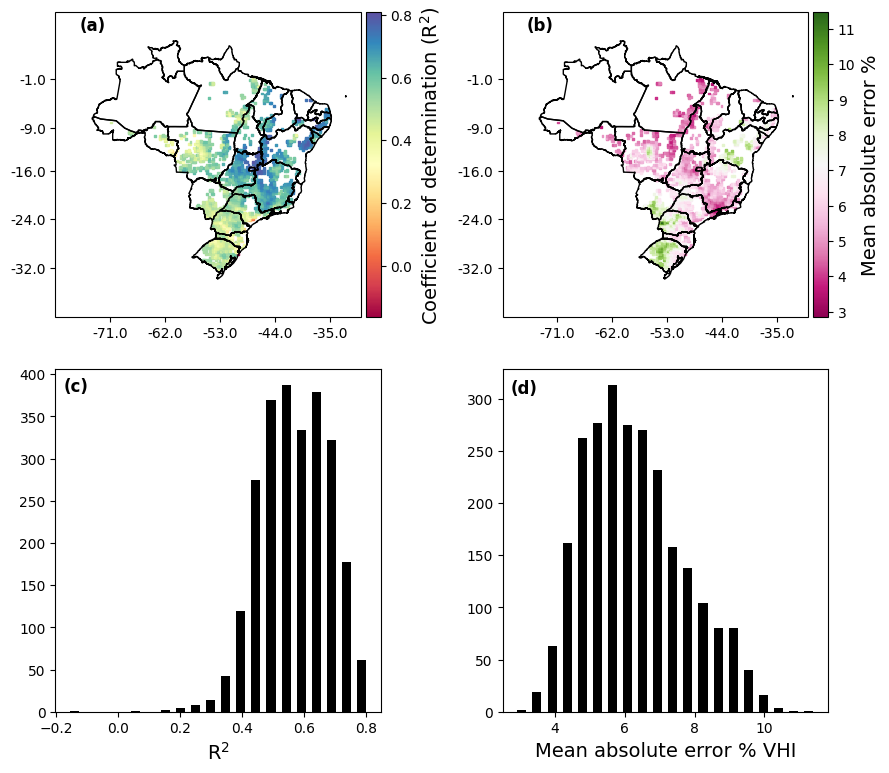

In [ ]:
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(2,2,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon, lat, c=GBM_r2, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=2)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel(r'Coefficient of determination (R$^2$)',fontsize='14')
ax1.title.set_text('')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
#ax1.axis('off')
ax1.set_xticks(xt)
ax1.set_xticklabels(ax1.get_xticks())
ax1.set_yticks(yt)
ax1.set_yticklabels(ax1.get_yticks())
ax1.text(np.min(xt)-5,np.max(yt)+8,s='(a)',weight='bold',fontsize=12)


ax1 = fig.add_subplot(2,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon, lat, c=GBM_mae, marker=',', transform=ccrs.PlateCarree(), cmap='PiYG',s=2)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
cbar = fig.colorbar(im, ax=ax1,cax=cax)
cbar.ax.set_ylabel(r'Mean absolute error %',fontsize='14')
ax1.title.set_text('')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
#ax1.axis('off')

ax1.set_xticks(xt)
ax1.set_xticklabels(ax1.get_xticks())
ax1.set_yticks(yt)
ax1.set_yticklabels(ax1.get_yticks())
ax1.text(np.min(xt)-5,np.max(yt)+8,s='(b)',weight='bold',fontsize=12)


ax1 = fig.add_subplot(2,2,3)
ax1.hist(GBM_r2,rwidth=0.6,bins=20,color='k')
ax1.set_xlabel(r'R$^2$',fontsize='14')
ax1.text(-0.175,380,s='(c)',weight='bold',fontsize=12)
ax1 = fig.add_subplot(2,2,4)
ax1.hist(GBM_mae,rwidth=0.6,bins=20,color='k')
ax1.set_xlabel(r'Mean absolute error % VHI',fontsize='14')
ax1.text(2.75,305,s='(d)',weight='bold',fontsize=12)
plt.subplots_adjust(wspace=0.45, hspace=0.20)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figures/GBM_mae_r2_maps.png',dpi=300)
plt.show()

In [ ]:
# Next do plot of average model performance per month
print(GBM_res)

           lat     lon  month  year  prediction      testy
0      -32.125 -53.375      1  2020   52.728965  62.826713
1      -32.125 -53.375      2  2020   56.842481  56.945423
2      -32.125 -53.375      3  2020   49.303301  39.100269
3      -32.125 -53.375      4  2020   38.548451  28.971330
4      -32.125 -53.375      5  2020   39.277928  31.129586
...        ...     ...    ...   ...         ...        ...
327842  -0.875 -47.625      8  2005   49.981668  44.921780
327843  -0.875 -47.625      9  2005   43.396509  35.035883
327844  -0.875 -47.625     10  2005   37.141274  35.797030
327845  -0.875 -47.625     11  2005   38.814913  38.391717
327846  -0.875 -47.625     12  2005   37.974347  45.080830

[327847 rows x 6 columns]


In [ ]:
# groupby month
def groupby_month(df):
  df_list=[]
  for index,df in df.groupby(['month']):
    df_list.append(df)
  return df_list

In [ ]:
def bias_score(target,prediction):
  diff=prediction - target
  return np.mean(diff)


In [ ]:
def monthly_metrics(df):
  df_list = groupby_month(df)
  r2_scores=[]
  mae_scores=[]
  month_number=[]
  mean_bias=[]
  for i in range(len(df_list)):
    dfi = df_list[i]
    # get r2 and mae per month
    r2_m = r2_score(dfi['testy'],dfi['prediction'])
    r2_scores.append(r2_m)
    # MAE scores
    mae_m = mean_absolute_error(dfi['testy'],dfi['prediction'])
    mae_scores.append(mae_m)
    #mean bias
    print(len(dfi['testy']))
    print(len(dfi['prediction']))
    m_bias = bias_score(dfi['testy'],dfi['prediction'])
    mean_bias.append(m_bias)
    month_number.append(dfi.reset_index()['month'].values[0])
  return r2_scores, mae_scores, month_number, mean_bias


In [ ]:
r2_scores, mae_scores, month_number, mean_bias =  monthly_metrics(GBM_res)

24984
24984
25263
25263
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760
27760


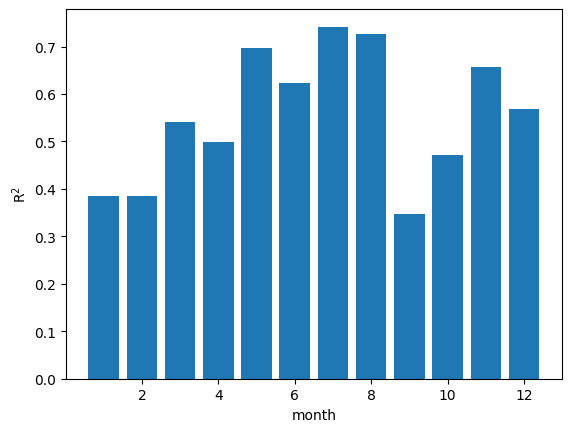

In [ ]:
fig = plt.figure()
plt.bar(month_number, r2_scores)
plt.ylabel(r'R$^2$')
plt.xlabel('month')
plt.show()

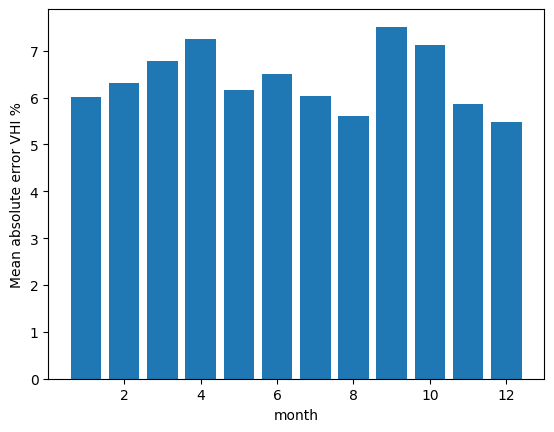

In [ ]:
fig = plt.figure()
plt.bar(month_number, mae_scores)
plt.ylabel(r'Mean absolute error VHI %')
plt.xlabel('month')
plt.show()

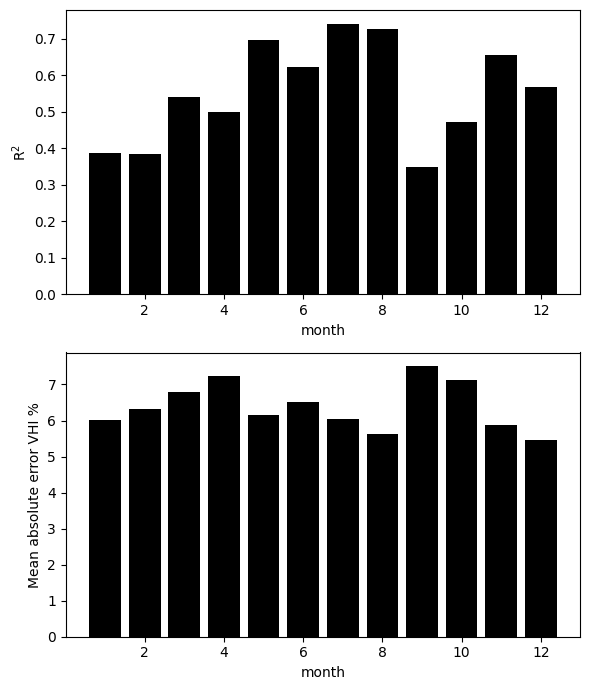

In [ ]:
fig = plt.figure(figsize=(6,7))
ax1 = fig.add_subplot(2,1,1)
ax1.bar(month_number, r2_scores,color='k')
ax1.set_ylabel(r'R$^2$')
ax1.set_xlabel('month')

ax2 = fig.add_subplot(2,1,2)
ax2.bar(month_number, mae_scores,color='k')
ax2.set_ylabel(r'Mean absolute error VHI %')
ax2.set_xlabel('month')

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Figures/GBM_mae_r2_monthly_bars.png',dpi=300)
plt.show()

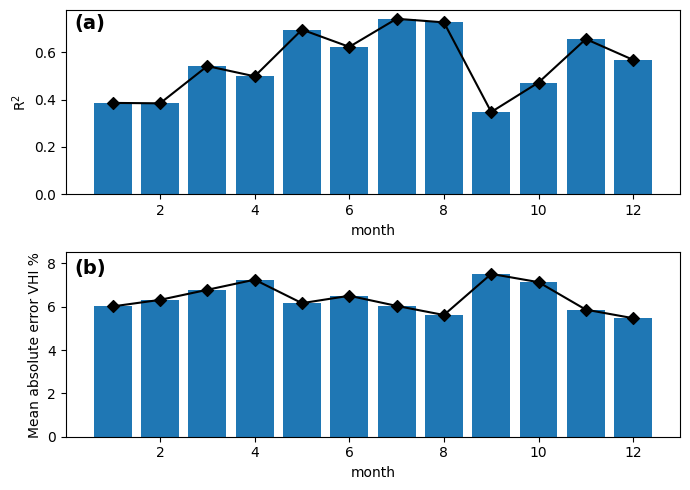

In [ ]:
# Do boxplots with line through middle, and just line plot
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(2,1,1)
ax1.bar(month_number, r2_scores)
ax1.scatter(month_number, r2_scores,color='k',marker='D')
ax1.plot(month_number, r2_scores,color='k')
ax1.set_ylabel(r'R$^2$')
ax1.set_xlabel('month')

ax1.text(0.20,0.70,s='(a)',weight='bold',fontsize=14)

ax2 = fig.add_subplot(2,1,2)
ax2.bar(month_number, mae_scores)
ax2.scatter(month_number, mae_scores,color='k',marker='D')
ax2.plot(month_number, mae_scores,color='k')
ax2.set_ylabel(r'Mean absolute error VHI %')
ax2.set_xlabel('month')
ax2.text(0.20,7.5,s='(b)',weight='bold',fontsize=14)
ax2.set_ylim(0,8.5)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Figures/GBM_mae_r2_monthly_lines_and_bars.png',dpi=300)
plt.show()

In [ ]:
print(mean_bias)

[-1.585765857403975, 0.8765441792939086, 2.006865743129448, 0.666563320037065, 0.09589720666640958, 0.2809409971627225, -2.180374512225541, -1.0656371131740319, 4.902070375018776, 3.77054859608872, 1.2903434278420953, -0.3271233222473427]


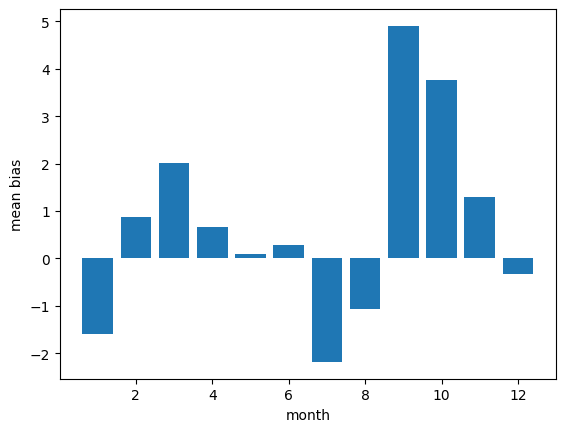

In [ ]:
# plot mean under or over prediction for each month to find why r2 score not good for january
fig = plt.figure()
plt.bar(month_number, mean_bias)
plt.ylabel(r'mean bias')
plt.xlabel('month')
plt.show()

In [ ]:
# Determine model performance below 40% VHI
print(GBM_res)

           lat     lon  month  year  prediction      testy
0      -32.125 -53.375      1  2020   52.728965  62.826713
1      -32.125 -53.375      2  2020   56.842481  56.945423
2      -32.125 -53.375      3  2020   49.303301  39.100269
3      -32.125 -53.375      4  2020   38.548451  28.971330
4      -32.125 -53.375      5  2020   39.277928  31.129586
...        ...     ...    ...   ...         ...        ...
327842  -0.875 -47.625      8  2005   49.981668  44.921780
327843  -0.875 -47.625      9  2005   43.396509  35.035883
327844  -0.875 -47.625     10  2005   37.141274  35.797030
327845  -0.875 -47.625     11  2005   38.814913  38.391717
327846  -0.875 -47.625     12  2005   37.974347  45.080830

[327847 rows x 6 columns]


In [ ]:
GBM_b40 = GBM_res[GBM_res['testy'] < 40]

In [ ]:
print(GBM_b40)

           lat     lon  month  year  prediction      testy
2      -32.125 -53.375      3  2020   49.303301  39.100269
3      -32.125 -53.375      4  2020   38.548451  28.971330
4      -32.125 -53.375      5  2020   39.277928  31.129586
5      -32.125 -53.375      6  2020   43.717189  39.273842
14     -31.875 -53.375      3  2020   43.271408  28.401949
...        ...     ...    ...   ...         ...        ...
327832  -1.125 -47.375     10  2005   35.335640  33.826728
327833  -1.125 -47.375     11  2005   37.448635  31.824605
327843  -0.875 -47.625      9  2005   43.396509  35.035883
327844  -0.875 -47.625     10  2005   37.141274  35.797030
327845  -0.875 -47.625     11  2005   38.814913  38.391717

[102797 rows x 6 columns]


In [ ]:
# Do simple plot first, compare model performance between GBM40 and GBM_res
GBM_b40_r2 = r2_score(GBM_b40['testy'],GBM_b40['prediction'])
GBM_b40_perror = mean_absolute_percentage_error(GBM_b40['testy'],GBM_b40['prediction'])

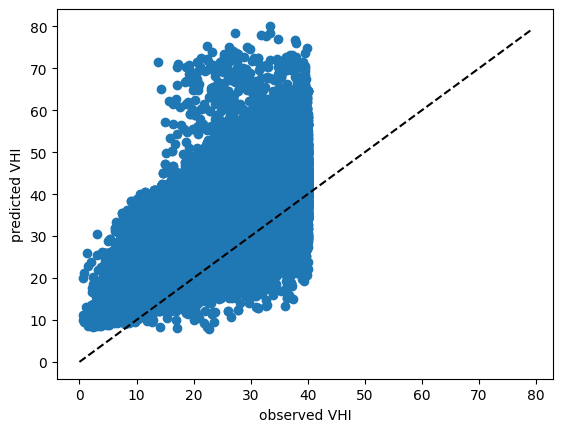

In [ ]:
line = np.arange(0,80,1)
fig = plt.figure()
plt.scatter(GBM_b40['testy'],GBM_b40['prediction'])
plt.plot(line,line,linestyle='--',color='k')
plt.xlabel('observed VHI')
plt.ylabel('predicted VHI')
plt.show()

In [ ]:
# Not a good way of showing so I should do pass fail type plot instead
print(GBM_res)
print(len(GBM_res))

           lat     lon  month  year  prediction      testy
0      -32.125 -53.375      1  2020   52.728965  62.826713
1      -32.125 -53.375      2  2020   56.842481  56.945423
2      -32.125 -53.375      3  2020   49.303301  39.100269
3      -32.125 -53.375      4  2020   38.548451  28.971330
4      -32.125 -53.375      5  2020   39.277928  31.129586
...        ...     ...    ...   ...         ...        ...
327842  -0.875 -47.625      8  2005   49.981668  44.921780
327843  -0.875 -47.625      9  2005   43.396509  35.035883
327844  -0.875 -47.625     10  2005   37.141274  35.797030
327845  -0.875 -47.625     11  2005   38.814913  38.391717
327846  -0.875 -47.625     12  2005   37.974347  45.080830

[327847 rows x 6 columns]
327847


In [ ]:
def pass_fail_threshold(df,var='testy'):
  hit_or_miss=[] # 1 is above 40, 0 is below 40
  for i in range(len(df)):
    if df[var].values[i] > 40:
      hit_or_miss.append(1)
    elif df[var].values[i] <= 40:
      hit_or_miss.append(0)
    else:
      print('error')
  return hit_or_miss

In [ ]:
testy_hm = pass_fail_threshold(GBM_res,var='testy')
prediction_hm = pass_fail_threshold(GBM_res,var='prediction')

In [ ]:
# Add to df then compare
GBM_res['obs pass fail'] = testy_hm

In [ ]:
GBM_res['pred pass fail'] = prediction_hm

In [ ]:
def class_metrics(df):
  # convert pass or fail into class metrics
  # 0= 0,0 True positive
  # 1=1,0 False positive
  # 2=0,1 False negative
  # 3=1,1 True negative
  metric_vals=[]
  for i in range(len(df)):
    if df['obs pass fail'].values[i] ==0 and df['pred pass fail'].values[i] ==0: # True positives
      metric_vals.append(0)
    elif df['obs pass fail'].values[i] ==1 and df['pred pass fail'].values[i] ==0: # false positives
      metric_vals.append(1)
    elif df['obs pass fail'].values[i] ==0 and df['pred pass fail'].values[i] ==1: # false negatives
      metric_vals.append(2)
    elif df['obs pass fail'].values[i] ==1 and df['pred pass fail'].values[i] ==1: # true negatives
      metric_vals.append(3)
  return metric_vals

In [ ]:
metric_vals_gbm = class_metrics(GBM_res)

In [ ]:
# add to dataframe
GBM_res['metric_vals'] = metric_vals_gbm

In [ ]:
def count_metrics(metric_vals):
  true_pos=0
  false_pos=0
  false_neg=0
  true_neg=0
  for i in range(len(metric_vals)):
    if metric_vals[i] == 0:
      true_pos+=1
    elif metric_vals[i]==1:
      false_pos+=1
    elif metric_vals[i]==2:
      false_neg+=1
    elif metric_vals[i]==3:
      true_neg+=1
  # combine ints together for matrix
  print(true_pos)
  print(false_pos)
  print(false_neg)
  print(true_neg)
  # combine together in array
  positives_array = np.asarray([true_pos, false_pos])
  negatives_array = np.asarray([false_neg,true_neg])
  conf_array = np.vstack((positives_array,negatives_array))
  print(conf_array.shape)
  print(conf_array)
  return conf_array

In [ ]:
conf_array_GBM = count_metrics(metric_vals_gbm)

61191
15176
41606
209874
(2, 2)
[[ 61191  15176]
 [ 41606 209874]]


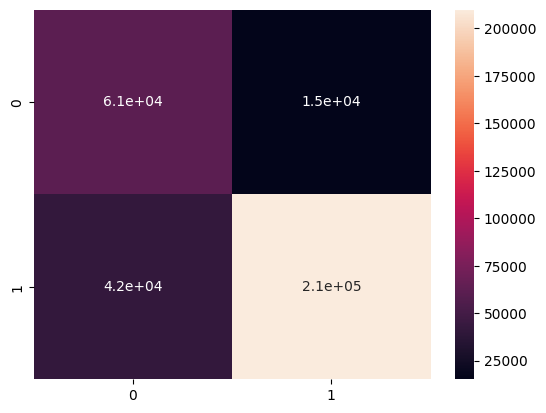

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(1,1,1)
sns.heatmap(conf_array_GBM,annot=True)
plt.show()

In [ ]:
recall_gbm = conf_array_GBM[0,0] / (conf_array_GBM[0,0]+conf_array_GBM[1,0])
precision_gbm = conf_array_GBM[0,0] / (conf_array_GBM[0,0]+conf_array_GBM[0,1])

In [ ]:
print(recall_gbm)
print(precision_gbm)

0.5952605620786598
0.8012754200112614


In [ ]:
metrics_list=[recall_gbm,precision_gbm]

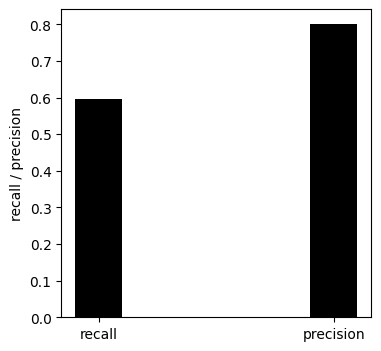

In [ ]:
fig = plt.figure(figsize=(4,4))
plt.bar(np.arange(len(metrics_list)),metrics_list,color='k',width=0.2,tick_label=['recall','precision'])
plt.ylabel('recall / precision')


plt.show()

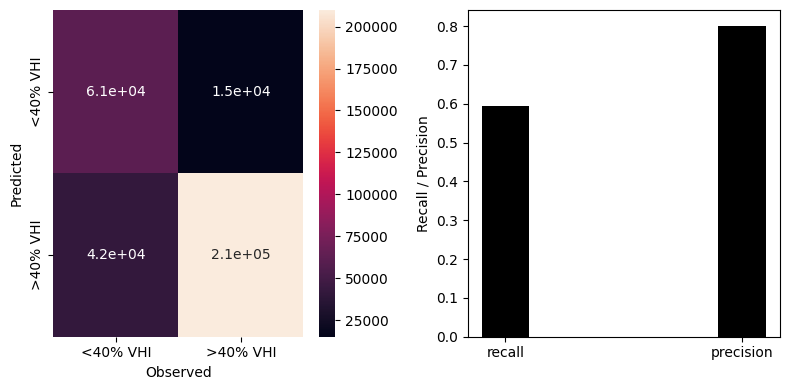

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,2,1)
sns.heatmap(conf_array_GBM,annot=True,ax=ax,xticklabels=['<40% VHI', '>40% VHI'], yticklabels=['<40% VHI', '>40% VHI'])
ax.set_ylabel('Predicted')
ax.set_xlabel('Observed')

ax=fig.add_subplot(1,2,2)
ax.bar(np.arange(len(metrics_list)),metrics_list,color='k',width=0.2,tick_label=['recall','precision'])
ax.set_ylabel('Recall / Precision')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figures/matrix_bar.png',dpi=300)
plt.show()

In [ ]:
# plot recall and precision as a map
print(GBM_res)

           lat     lon  month  year  prediction      testy  obs pass fail  \
0      -32.125 -53.375      1  2020   52.728965  62.826713              1   
1      -32.125 -53.375      2  2020   56.842481  56.945423              1   
2      -32.125 -53.375      3  2020   49.303301  39.100269              0   
3      -32.125 -53.375      4  2020   38.548451  28.971330              0   
4      -32.125 -53.375      5  2020   39.277928  31.129586              0   
...        ...     ...    ...   ...         ...        ...            ...   
327842  -0.875 -47.625      8  2005   49.981668  44.921780              1   
327843  -0.875 -47.625      9  2005   43.396509  35.035883              0   
327844  -0.875 -47.625     10  2005   37.141274  35.797030              0   
327845  -0.875 -47.625     11  2005   38.814913  38.391717              0   
327846  -0.875 -47.625     12  2005   37.974347  45.080830              1   

        pred pass fail  metric_vals  
0                    1            3  

In [ ]:
# Get recall and precision per grid cell
def grid_cell_drought_metrics(res_df):
  res_df_list = groupby_gc(res_df)
  # get numnber of false pos values etc per grid cell
  conf_matrices=[]
  recalls_list=[]
  precisions_list=[]
  lat_list=[]
  lon_list=[]
  for gc in range(len(res_df_list)):
    conf_mat_i = count_metrics(res_df_list[gc]['metric_vals'].values)
    conf_matrices.append(conf_mat_i)
    recall_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[1,0])
    precision_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[0,1])
    ##
    recalls_list.append(recall_i)
    precisions_list.append(precision_i)
    ## Get lat and lon values to map with precision and recall
    lat_list.append(res_df_list[gc]['lat'].values[0])
    lon_list.append(res_df_list[gc]['lon'].values[0])
  return recalls_list, precisions_list, lat_list, lon_list

In [ ]:
recalls_GBM, precisions_GBM, lat_list, lon_list = grid_cell_drought_metrics(GBM_res)

8
2
18
90
(2, 2)
[[ 8  2]
 [18 90]]
9
1
15
93
(2, 2)
[[ 9  1]
 [15 93]]
14
1
13
90
(2, 2)
[[14  1]
 [13 90]]
14
6
24
74
(2, 2)
[[14  6]
 [24 74]]
11
2
12
93
(2, 2)
[[11  2]
 [12 93]]
17
7
21
73
(2, 2)
[[17  7]
 [21 73]]
14
5
15
84
(2, 2)
[[14  5]
 [15 84]]
12
2
13
91
(2, 2)
[[12  2]
 [13 91]]
15
1
12
90
(2, 2)
[[15  1]
 [12 90]]
15
0
13
90
(2, 2)
[[15  0]
 [13 90]]
14
1
15
88
(2, 2)
[[14  1]
 [15 88]]
6
0
12
100
(2, 2)
[[  6   0]
 [ 12 100]]
13
1
12
92
(2, 2)
[[13  1]
 [12 92]]
30
2
28
177
(2, 2)
[[ 30   2]
 [ 28 177]]
10
1
12
95
(2, 2)
[[10  1]
 [12 95]]
10
0
11
97
(2, 2)
[[10  0]
 [11 97]]
6
0
8
104
(2, 2)
[[  6   0]
 [  8 104]]
9
0
11
98
(2, 2)
[[ 9  0]
 [11 98]]
26
0
28
183
(2, 2)
[[ 26   0]
 [ 28 183]]
19
1
16
82
(2, 2)
[[19  1]
 [16 82]]
17
2
20
79
(2, 2)
[[17  2]
 [20 79]]
18
1
18
81
(2, 2)
[[18  1]
 [18 81]]
11
1
15
91
(2, 2)
[[11  1]
 [15 91]]
8
1
10
99
(2, 2)
[[ 8  1]
 [10 99]]
7
0
11
100
(2, 2)
[[  7   0]
 [ 11 100]]
6
1
11
100
(2, 2)
[[  6   1]
 [ 11 100]]
11
1
14
92
(2, 2)

<ipython-input-301-32bfb85fdc0e>:14: RuntimeWarning: invalid value encountered in scalar divide
  precision_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[0,1])


(2, 2)
[[  4   1]
 [ 12 101]]
11
2
13
92
(2, 2)
[[11  2]
 [13 92]]
17
2
14
85
(2, 2)
[[17  2]
 [14 85]]
19
2
13
84
(2, 2)
[[19  2]
 [13 84]]
16
2
20
80
(2, 2)
[[16  2]
 [20 80]]
6
1
15
96
(2, 2)
[[ 6  1]
 [15 96]]
3
1
14
100
(2, 2)
[[  3   1]
 [ 14 100]]
19
5
15
79
(2, 2)
[[19  5]
 [15 79]]
12
4
12
90
(2, 2)
[[12  4]
 [12 90]]
12
3
10
93
(2, 2)
[[12  3]
 [10 93]]
10
1
14
93
(2, 2)
[[10  1]
 [14 93]]
8
5
42
182
(2, 2)
[[  8   5]
 [ 42 182]]
10
2
12
94
(2, 2)
[[10  2]
 [12 94]]
8
2
26
82
(2, 2)
[[ 8  2]
 [26 82]]
9
1
28
80
(2, 2)
[[ 9  1]
 [28 80]]
0
7
18
93
(2, 2)
[[ 0  7]
 [18 93]]
0
0
15
103
(2, 2)
[[  0   0]
 [ 15 103]]
19
5
24
70
(2, 2)
[[19  5]
 [24 70]]
19
6
17
76
(2, 2)
[[19  6]
 [17 76]]
15
4
20
79
(2, 2)
[[15  4]
 [20 79]]
40
9
42
146
(2, 2)
[[ 40   9]
 [ 42 146]]
30
13
36
158
(2, 2)
[[ 30  13]
 [ 36 158]]
34
3
48
152
(2, 2)
[[ 34   3]
 [ 48 152]]
2
1
12
103
(2, 2)
[[  2   1]
 [ 12 103]]
10
5
14
89
(2, 2)
[[10  5]
 [14 89]]
18
5
17
78
(2, 2)
[[18  5]
 [17 78]]
40
11
46
140
(2, 

<ipython-input-301-32bfb85fdc0e>:13: RuntimeWarning: invalid value encountered in scalar divide
  recall_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[1,0])


Streaming output truncated to the last 5000 lines.
[[14  3]
 [10 91]]
14
3
11
90
(2, 2)
[[14  3]
 [11 90]]
14
3
4
97
(2, 2)
[[14  3]
 [ 4 97]]
15
2
6
95
(2, 2)
[[15  2]
 [ 6 95]]
27
1
15
75
(2, 2)
[[27  1]
 [15 75]]
30
6
18
64
(2, 2)
[[30  6]
 [18 64]]
26
10
36
165
(2, 2)
[[ 26  10]
 [ 36 165]]
15
1
19
83
(2, 2)
[[15  1]
 [19 83]]
25
7
15
71
(2, 2)
[[25  7]
 [15 71]]
32
6
11
69
(2, 2)
[[32  6]
 [11 69]]
44
8
12
54
(2, 2)
[[44  8]
 [12 54]]
47
6
15
50
(2, 2)
[[47  6]
 [15 50]]
48
7
14
49
(2, 2)
[[48  7]
 [14 49]]
43
9
14
52
(2, 2)
[[43  9]
 [14 52]]
40
3
11
64
(2, 2)
[[40  3]
 [11 64]]
43
5
13
57
(2, 2)
[[43  5]
 [13 57]]
36
6
13
63
(2, 2)
[[36  6]
 [13 63]]
64
26
48
99
(2, 2)
[[64 26]
 [48 99]]
17
9
23
69
(2, 2)
[[17  9]
 [23 69]]
15
7
14
82
(2, 2)
[[15  7]
 [14 82]]
21
7
17
73
(2, 2)
[[21  7]
 [17 73]]
13
6
19
80
(2, 2)
[[13  6]
 [19 80]]
16
7
16
79
(2, 2)
[[16  7]
 [16 79]]
16
7
18
77
(2, 2)
[[16  7]
 [18 77]]
29
10
20
59
(2, 2)
[[29 10]
 [20 59]]
60
3
16
39
(2, 2)
[[60  3]
 [16 39]]

In [ ]:
xt = np.linspace(np.min(lon_list),np.max(lon_list),5)
xt = np.round(xt,decimals=0)

yt = np.linspace(np.min(lat_list),np.max(lat_list),5)
yt = np.round(yt,decimals=0)

<ipython-input-356-5b30b16d04bf>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


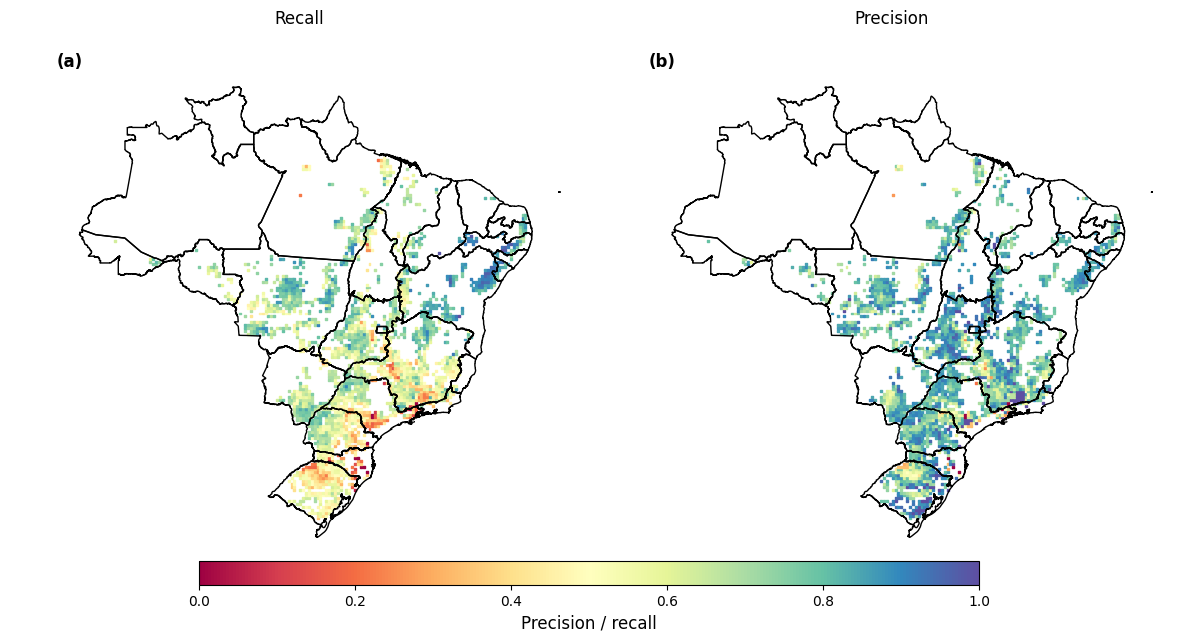

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=recalls_GBM, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=2)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel(r'Recall',fontsize='14')
#ax1.title.set_text('Recall')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
ax1.set_title('Recall')
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')
#ax1.set_xticks(xt)
#ax1.set_xticklabels(ax1.get_xticks())
#ax1.set_yticks(yt)
#ax1.set_yticklabels(ax1.get_yticks())
ax1.text(np.min(xt)-5,np.max(yt)+8,s='(a)',weight='bold',fontsize=12)

ax1 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
im=ax1.scatter(lon_list, lat_list, c=precisions_GBM, marker=',', transform=ccrs.PlateCarree(), cmap='Spectral',s=2)
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel(r'Precision',fontsize='14')
ax1.set_title('Precision')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.add_feature(shape_feature)
#ax1.add_feature(cf.LAND)
#ax1.add_feature(cf.OCEAN)
ax1.axis('off')
#ax1.set_xticks(xt)
#ax1.set_xticklabels(ax1.get_xticks())
#ax1.set_yticks(yt)
#ax1.set_yticklabels(ax1.get_yticks())
ax1.text(np.min(xt)-5,np.max(yt)+8,s='(b)',weight='bold',fontsize=12)
#plt.subplots_adjust(wspace=0.2, hspace=0.20)

cbar_ax = fig.add_axes([0.17, 0.17, 0.65, 0.03])
cbar=fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
cbar.ax.set_xlabel('Precision / recall',fontsize='12')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figures/recall_precision_map.png',dpi=300)
plt.show()

In [ ]:
# boxplot of recalls and precisions
print(len(recalls_GBM))
print(len(precisions_GBM))

2497
2497


In [ ]:
recall_labels = ['recall']*len(recalls_GBM)
precision_labels = ['precision']*len(precisions_GBM)
labels = recall_labels + precision_labels
values = recalls_GBM + precisions_GBM

In [ ]:
rp_box_df = pd.DataFrame({'labels':labels,'values':values})


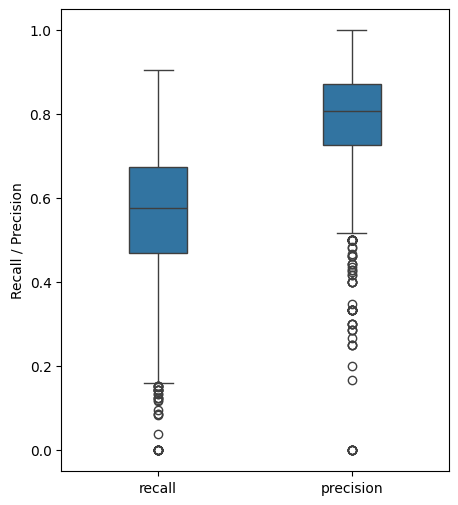

In [ ]:
fig = plt.figure(figsize=(5,6))
ax=fig.add_subplot(1,1,1)
g=sns.boxplot(data=rp_box_df,x='labels',y='values',ax=ax,width=0.3)
ax.set_ylabel('Recall / Precision')
ax.set_xlabel('')
plt.savefig('/content/drive/MyDrive/Figures/recall_precision_boxplots.png',dpi=300)
plt.show()


In [ ]:
print(GBM_res)

           lat     lon  month  year  prediction      testy  obs pass fail  \
0      -32.125 -53.375      1  2020   52.728965  62.826713              1   
1      -32.125 -53.375      2  2020   56.842481  56.945423              1   
2      -32.125 -53.375      3  2020   49.303301  39.100269              0   
3      -32.125 -53.375      4  2020   38.548451  28.971330              0   
4      -32.125 -53.375      5  2020   39.277928  31.129586              0   
...        ...     ...    ...   ...         ...        ...            ...   
327842  -0.875 -47.625      8  2005   49.981668  44.921780              1   
327843  -0.875 -47.625      9  2005   43.396509  35.035883              0   
327844  -0.875 -47.625     10  2005   37.141274  35.797030              0   
327845  -0.875 -47.625     11  2005   38.814913  38.391717              0   
327846  -0.875 -47.625     12  2005   37.974347  45.080830              1   

        pred pass fail  metric_vals  
0                    1            3  

In [ ]:
# combine with SOI to get recall and precision with mode of SOI
fileObj = open('/content/drive/MyDrive/SOI_df.pkl', 'rb')
SOI_df = pickle.load(fileObj)
fileObj.close()
#print(SOI_df)
SOI_df0 = pd.DataFrame({'lat':SOI_df[0]['lat'],'lon':SOI_df[0]['lon'],'month':SOI_df[0]['month'],'year':SOI_df[0]['year'],'SOI mode':SOI_df[0]['SOI mode']})
SOI_df1 = pd.DataFrame({'lat':SOI_df[1]['lat'],'lon':SOI_df[1]['lon'],'month':SOI_df[1]['month'],'year':SOI_df[1]['year'],'SOI mode':SOI_df[1]['SOI mode']})
SOI_df_list = [SOI_df0,SOI_df1]
SOI_df_concat = pd.concat([SOI_df0,SOI_df1])

In [ ]:
print(SOI_df_concat)

           lat     lon  month  year  SOI mode
3      -32.125 -53.375      2  2020      -1.0
4      -32.125 -53.375      2  2020      -1.0
5      -32.125 -53.375      2  2020      -1.0
6      -32.125 -53.375      3  2020      -1.0
7      -32.125 -53.375      3  2020      -1.0
...        ...     ...    ...   ...       ...
360900  -0.875 -47.625      3  2005       1.0
360903  -0.875 -47.625      6  2005       1.0
360904  -0.875 -47.625      7  2005       1.0
360906  -0.875 -47.625      9  2005       1.0
360907  -0.875 -47.625     10  2005       1.0

[357575 rows x 5 columns]


In [ ]:
# merge GBM_res df with SOI_df concat
GBM_res_SOI = GBM_res.merge(SOI_df_concat,on=['lat','lon','month','year'])

In [ ]:
# split data set by SOI mode then put through function to get precision and recall
def groupby_soi(df):
  df_list=[]
  for index,df in df.groupby(['SOI mode']):
    df_list.append(df)
  return df_list

In [ ]:
GBM_res_SOI_list = groupby_soi(GBM_res_SOI)
print(GBM_res_SOI_list[0])

           lat     lon  month  year  prediction      testy  obs pass fail  \
9      -32.125 -53.375      2  2020   56.842481  56.945423              1   
10     -32.125 -53.375      2  2020   56.842481  56.945423              1   
11     -32.125 -53.375      2  2020   56.842481  56.945423              1   
12     -32.125 -53.375      2  2020   56.842481  56.945423              1   
13     -32.125 -53.375      2  2020   56.842481  56.945423              1   
...        ...     ...    ...   ...         ...        ...            ...   
771235  -0.875 -47.625      2  2005   46.043018  47.708051              1   
771237  -0.875 -47.625      4  2005   48.896132  44.197981              1   
771238  -0.875 -47.625      5  2005   44.565597  45.429215              1   
771241  -0.875 -47.625      8  2005   49.981668  44.921780              1   
771244  -0.875 -47.625     11  2005   38.814913  38.391717              0   

        pred pass fail  metric_vals  SOI mode  
9                    1     

In [ ]:
recalls_GBM0, precisions_GBM0, lat_list0, lon_list0 = grid_cell_drought_metrics(GBM_res_SOI_list[0])
recalls_GBM1, precisions_GBM1, lat_list1, lon_list1 = grid_cell_drought_metrics(GBM_res_SOI_list[1])

0
0
23
41
(2, 2)
[[ 0  0]
 [23 41]]
1
0
22
41
(2, 2)
[[ 1  0]
 [22 41]]
12
0
13
39
(2, 2)
[[12  0]
 [13 39]]
11
10
18
25
(2, 2)
[[11 10]
 [18 25]]
2
1
13
48
(2, 2)
[[ 2  1]
 [13 48]]
15
2
14
33
(2, 2)
[[15  2]
 [14 33]]
13
3
14
34
(2, 2)
[[13  3]
 [14 34]]
11
1
14
38
(2, 2)
[[11  1]
 [14 38]]
19
0
14
31
(2, 2)
[[19  0]
 [14 31]]
19
0
13
32
(2, 2)
[[19  0]
 [13 32]]
19
0
14
31
(2, 2)
[[19  0]
 [14 31]]
0
0
13
51
(2, 2)
[[ 0  0]
 [13 51]]
10
0
13
41
(2, 2)
[[10  0]
 [13 41]]
104
8
104
301
(2, 2)
[[104   8]
 [104 301]]
9
0
13
42
(2, 2)
[[ 9  0]
 [13 42]]
9
0
13
42
(2, 2)
[[ 9  0]
 [13 42]]
0
0
12
52
(2, 2)
[[ 0  0]
 [12 52]]
9
0
12
43
(2, 2)
[[ 9  0]
 [12 43]]
80
0
104
333
(2, 2)
[[ 80   0]
 [104 333]]
15
0
14
35
(2, 2)
[[15  0]
 [14 35]]
14
0
17
33
(2, 2)
[[14  0]
 [17 33]]
16
0
14
34
(2, 2)
[[16  0]
 [14 34]]
2
1
22
39
(2, 2)
[[ 2  1]
 [22 39]]
1
1
13
49
(2, 2)
[[ 1  1]
 [13 49]]
0
0
13
51
(2, 2)
[[ 0  0]
 [13 51]]
0
0
13
51
(2, 2)
[[ 0  0]
 [13 51]]
10
0
12
42
(2, 2)
[[10  0]
 [12 42]]

<ipython-input-301-32bfb85fdc0e>:14: RuntimeWarning: invalid value encountered in scalar divide
  precision_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[0,1])



2
14
46
(2, 2)
[[ 2  2]
 [14 46]]
3
1
14
46
(2, 2)
[[ 3  1]
 [14 46]]
2
0
13
49
(2, 2)
[[ 2  0]
 [13 49]]
24
73
120
300
(2, 2)
[[ 24  73]
 [120 300]]
1
2
15
46
(2, 2)
[[ 1  2]
 [15 46]]
1
1
12
50
(2, 2)
[[ 1  1]
 [12 50]]
1
1
11
51
(2, 2)
[[ 1  1]
 [11 51]]
1
0
12
51
(2, 2)
[[ 1  0]
 [12 51]]
2
1
22
39
(2, 2)
[[ 2  1]
 [22 39]]
1
1
26
36
(2, 2)
[[ 1  1]
 [26 36]]
19
0
16
29
(2, 2)
[[19  0]
 [16 29]]
9
1
24
30
(2, 2)
[[ 9  1]
 [24 30]]
14
1
14
35
(2, 2)
[[14  1]
 [14 35]]
11
2
14
37
(2, 2)
[[11  2]
 [14 37]]
1
11
11
41
(2, 2)
[[ 1 11]
 [11 41]]
1
12
12
39
(2, 2)
[[ 1 12]
 [12 39]]
1
3
13
47
(2, 2)
[[ 1  3]
 [13 47]]
1
3
15
45
(2, 2)
[[ 1  3]
 [15 45]]
1
3
14
46
(2, 2)
[[ 1  3]
 [14 46]]
2
2
14
46
(2, 2)
[[ 2  2]
 [14 46]]
1
2
12
49
(2, 2)
[[ 1  2]
 [12 49]]
1
2
15
46
(2, 2)
[[ 1  2]
 [15 46]]
12
2
15
35
(2, 2)
[[12  2]
 [15 35]]
16
9
176
316
(2, 2)
[[ 16   9]
 [176 316]]
1
1
12
50
(2, 2)
[[ 1  1]
 [12 50]]
1
1
11
51
(2, 2)
[[ 1  1]
 [11 51]]
1
1
23
39
(2, 2)
[[ 1  1]
 [23 39]]
3
0
24
3

<ipython-input-301-32bfb85fdc0e>:13: RuntimeWarning: invalid value encountered in scalar divide
  recall_i = conf_mat_i[0,0] / (conf_mat_i[0,0]+conf_mat_i[1,0])


Streaming output truncated to the last 5000 lines.
[[ 8  2]
 [ 4 95]]
8
2
5
94
(2, 2)
[[ 8  2]
 [ 5 94]]
8
1
3
97
(2, 2)
[[ 8  1]
 [ 3 97]]
9
1
9
90
(2, 2)
[[ 9  1]
 [ 9 90]]
21
1
15
72
(2, 2)
[[21  1]
 [15 72]]
23
10
15
61
(2, 2)
[[23 10]
 [15 61]]
48
40
160
624
(2, 2)
[[ 48  40]
 [160 624]]
9
0
22
78
(2, 2)
[[ 9  0]
 [22 78]]
14
3
13
79
(2, 2)
[[14  3]
 [13 79]]
17
3
12
77
(2, 2)
[[17  3]
 [12 77]]
29
11
12
57
(2, 2)
[[29 11]
 [12 57]]
29
2
15
63
(2, 2)
[[29  2]
 [15 63]]
30
1
14
64
(2, 2)
[[30  1]
 [14 64]]
28
3
13
65
(2, 2)
[[28  3]
 [13 65]]
27
2
3
77
(2, 2)
[[27  2]
 [ 3 77]]
29
1
11
68
(2, 2)
[[29  1]
 [11 68]]
21
5
4
79
(2, 2)
[[21  5]
 [ 4 79]]
272
152
128
320
(2, 2)
[[272 152]
 [128 320]]
25
5
18
61
(2, 2)
[[25  5]
 [18 61]]
24
0
15
70
(2, 2)
[[24  0]
 [15 70]]
26
2
16
65
(2, 2)
[[26  2]
 [16 65]]
22
0
19
68
(2, 2)
[[22  0]
 [19 68]]
23
1
16
69
(2, 2)
[[23  1]
 [16 69]]
23
2
16
68
(2, 2)
[[23  2]
 [16 68]]
30
20
21
38
(2, 2)
[[30 20]
 [21 38]]
81
2
6
20
(2, 2)
[[81  2]
 [ 6 2

In [ ]:
# make into dataframe and plot as boxplot
# 0 = negative = el nino
recall_labels0 = ['recall']*len(recalls_GBM0)
precision_labels0 = ['precision']*len(precisions_GBM0)
labels0 = recall_labels0 + precision_labels0
values0 = recalls_GBM0 + precisions_GBM0
print(len(values0))
mode_0 = [r'El Nino']*len(values0)
print(mode_0)

4994
['El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El Nino', 'El 

In [ ]:
# 1= positive = la nina
recall_labels1 = ['recall']*len(recalls_GBM1)
precision_labels1 = ['precision']*len(precisions_GBM1)
labels1 = recall_labels1 + precision_labels1
values1 = recalls_GBM1 + precisions_GBM1
mode_1 = [r'La Nina']*len(values1)
print(mode_1)

['La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina', 'La Nina'

In [ ]:
# combine 1 and 2
recall_labels = recall_labels0 + recall_labels1
precision_labels = precision_labels0 + precision_labels1
labels = labels0 + labels1
values = values0 + values1
mode = mode_0 + mode_1
## make dataframe
print(len(labels))
print(len(values))
print(4994*2)
mode_pr_box_df = pd.DataFrame({'metric':labels,'values':values,'mode':mode})

9988
9988
9988


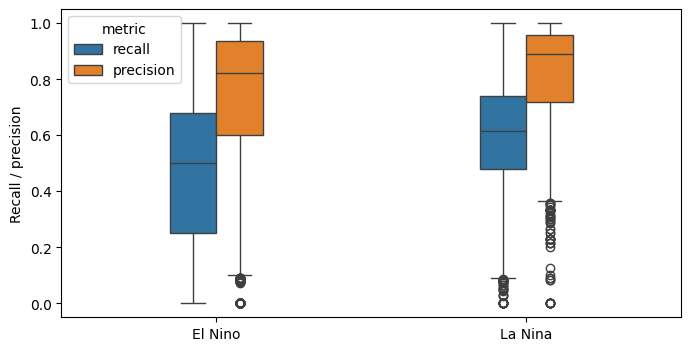

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(1,1,1)
g=sns.boxplot(data=mode_pr_box_df,x='mode',y='values',hue='metric',ax=ax,width=0.3)
ax.set_ylabel('Recall / precision')
ax.set_xlabel('')

plt.savefig('/content/drive/MyDrive/Figures/recall_precision_enso_boxplots.png',dpi=300)
plt.show()

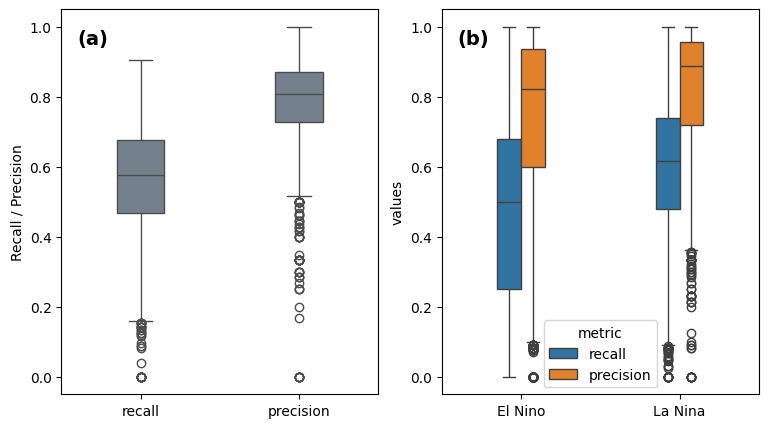

In [ ]:
fig = plt.figure(figsize=(9,5))
ax=fig.add_subplot(1,2,1)
g=sns.boxplot(data=rp_box_df,x='labels',y='values',ax=ax,width=0.3,color='slategrey')
ax.set_ylabel('Recall / Precision')
ax.set_xlabel('')
ax.text(-0.4,0.95,s='(a)',weight='bold',fontsize=14)

ax=fig.add_subplot(1,2,2)
g=sns.boxplot(data=mode_pr_box_df,x='mode',y='values',hue='metric',ax=ax,width=0.3)
ax.set_xlabel('')
ax.text(-0.4,0.95,s='(b)',weight='bold',fontsize=14)

plt.savefig('/content/drive/MyDrive/Figures/recall_precision_boxplots_joined.png',dpi=300)
plt.show()

In [ ]:
# load in testx data then plot correlations with VHI per grid cell against model performance
df = pd.read_csv('/content/drive/MyDrive/VHI_spei_rzsm_dataset.csv')
print(df)

           lon     lat      vhi-1   precip-1      rzsm-1  spei1-1m  spei2-1m  \
0      -53.375 -32.125  70.414172  259.20056   98.021910  2.192168  1.313241   
1      -53.375 -32.125  79.323750  146.58607   98.162980  1.228278  2.453098   
2      -53.375 -32.125  77.111895  184.82845   97.594270  1.472914  1.588110   
3      -53.375 -32.125  64.150561  108.86273   97.605330  1.680747  1.751371   
4      -53.375 -32.125  54.270359  145.90760  100.000000  1.641170  1.900034   
...        ...     ...        ...        ...         ...       ...       ...   
627650 -47.625  -0.875  49.922513  294.35620   80.138200  1.130223  0.881931   
627651 -47.625  -0.875  52.101102  125.48111   88.888840  2.664571  2.250521   
627652 -47.625  -0.875  46.753572   24.13338   77.834076  2.523025  3.002636   
627653 -47.625  -0.875  48.627606   71.58264   69.860950  1.286047  2.275886   
627654 -47.625  -0.875  47.450658  130.48245   83.223434  1.721121  1.885239   

        spei3-1m   spi01-1   spi02-1   

In [ ]:
# use pandas merge to get a comparison dataframe
GBM_res_x = GBM_res.merge(df,on=['lat','lon','month','year'])
print(GBM_res_x)
print(GBM_res)

           lat     lon  month  year  prediction      testy  obs pass fail  \
0      -32.125 -53.375      1  2020   52.728965  62.826713              1   
1      -32.125 -53.375      1  2020   52.728965  62.826713              1   
2      -32.125 -53.375      1  2020   52.728965  62.826713              1   
3      -32.125 -53.375      2  2020   56.842481  56.945423              1   
4      -32.125 -53.375      2  2020   56.842481  56.945423              1   
...        ...     ...    ...   ...         ...        ...            ...   
393686  -0.875 -47.625      8  2005   49.981668  44.921780              1   
393687  -0.875 -47.625      9  2005   43.396509  35.035883              0   
393688  -0.875 -47.625     10  2005   37.141274  35.797030              0   
393689  -0.875 -47.625     11  2005   38.814913  38.391717              0   
393690  -0.875 -47.625     12  2005   37.974347  45.080830              1   

        pred pass fail  metric_vals      vhi-1  ...  spei1-1m  spei2-1m  \


In [ ]:
def per_gc_metrics(df,var='VHI'):
  m1_df_anom_gc_list = groupby_gc(df)
  lat_list=[]
  lon_list=[]
  var_ccoef=[]
  mean_var=[]
  _r2=[]
  _mae=[]
  for i in range(len(m1_df_anom_gc_list)):
    # get average vhi and plot
    var_ccoef.append(pearsonr(m1_df_anom_gc_list[i][var],m1_df_anom_gc_list[i]['VHI'])[0])
    mean_var.append(np.mean(m1_df_anom_gc_list[i][var]))
    _r2.append(r2_score(m1_df_anom_gc_list[i]['testy'],m1_df_anom_gc_list[i]['prediction']))
    _mae.append(mean_absolute_error(m1_df_anom_gc_list[i]['testy'],m1_df_anom_gc_list[i]['prediction']))
    # get latitude and longitude coordinates
    lat = m1_df_anom_gc_list[i]['lat'].values[0]
    lat_list.append(lat)
    lon = m1_df_anom_gc_list[i]['lon'].values[0]
    lon_list.append(lon)
  return lat_list, lon_list, var_ccoef, _r2, _mae, mean_var

In [ ]:
print(GBM_res_x.columns)

Index(['lat', 'lon', 'month', 'year', 'prediction', 'testy', 'obs pass fail',
       'pred pass fail', 'metric_vals', 'vhi-1', 'precip-1', 'rzsm-1',
       'spei1-1m', 'spei2-1m', 'spei3-1m', 'spi01-1', 'spi02-1', 'spi03-1',
       'pev-1', 'longrad-1', 't2m-1', 'VHI'],
      dtype='object')


In [ ]:
lat_list, lon_list, rzsm_ccoef, gbm_r2, gbm_mae, mean_rzsm = per_gc_metrics(GBM_res_x,'rzsm-1')
lat_list, lon_list, spei3_ccoef, gbm_r2, gbm_mae, mean_spei3 = per_gc_metrics(GBM_res_x,'spei3-1m')
lat_list, lon_list, spi3_ccoef, gbm_r2, gbm_mae, mean_spi3 = per_gc_metrics(GBM_res_x,'spi03-1')
lat_list, lon_list, spei2_ccoef, gbm_r2, gbm_mae, mean_spei2 = per_gc_metrics(GBM_res_x,'spei2-1m')
lat_list, lon_list, spi2_ccoef, gbm_r2, gbm_mae, mean_spi2 = per_gc_metrics(GBM_res_x,'spi02-1')
lat_list, lon_list, spei1_ccoef, gbm_r2, gbm_mae, mean_spei1 = per_gc_metrics(GBM_res_x,'spei1-1m')
lat_list, lon_list, spi1_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'spi01-1')

In [ ]:
RZSM_vhi_ccoef_df = pd.DataFrame({'lat':lat_list,'lon':lon_list,'rzsm_ccoef':rzsm_ccoef,'gbm_r2':gbm_r2,'gbm_mae':gbm_mae, 'mean rzsm':mean_rzsm})

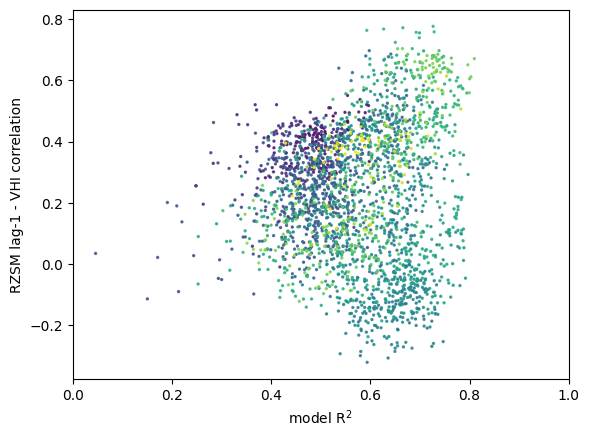

In [ ]:
#plot
fig = plt.figure()
plt.scatter(gbm_r2,rzsm_ccoef,s=2,alpha=0.8,c=lat_list)
plt.ylabel('RZSM lag-1 - VHI correlation')
plt.xlabel(r'model R$^2$')
plt.xlim(0,1)
plt.show()

In [ ]:
clusters2 = pd.read_csv('/content/drive/MyDrive/RZSM_2clusters.csv')
print(clusters2)

         lat     lon  clusters
0    -32.125 -53.375         0
1    -31.875 -53.375         0
2    -31.875 -53.125         0
3    -31.875 -52.875         0
4    -31.875 -52.625         0
...      ...     ...       ...
2492  -1.125 -48.125         1
2493  -1.125 -47.875         1
2494  -1.125 -47.625         1
2495  -1.125 -47.375         1
2496  -0.875 -47.625         1

[2497 rows x 3 columns]


In [ ]:
RZSM_vhi_ccoef_df_c = RZSM_vhi_ccoef_df.merge(clusters2,on=['lat','lon'])

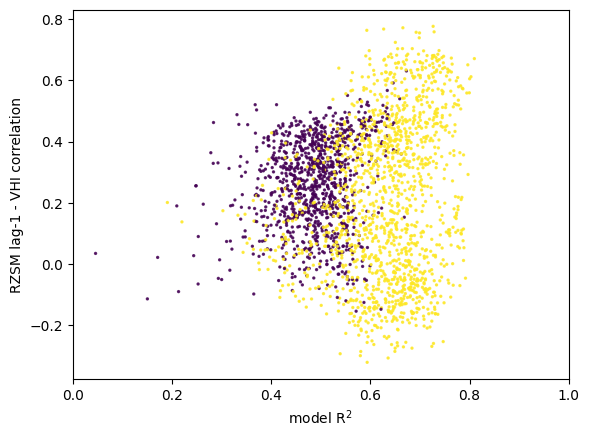

In [ ]:
fig = plt.figure()
plt.scatter(RZSM_vhi_ccoef_df_c['gbm_r2'],RZSM_vhi_ccoef_df_c['rzsm_ccoef'],s=2,alpha=0.8,c=RZSM_vhi_ccoef_df_c['clusters'])
plt.ylabel('RZSM lag-1 - VHI correlation')
plt.xlabel(r'model R$^2$')
plt.xlim(0,1)
plt.show()

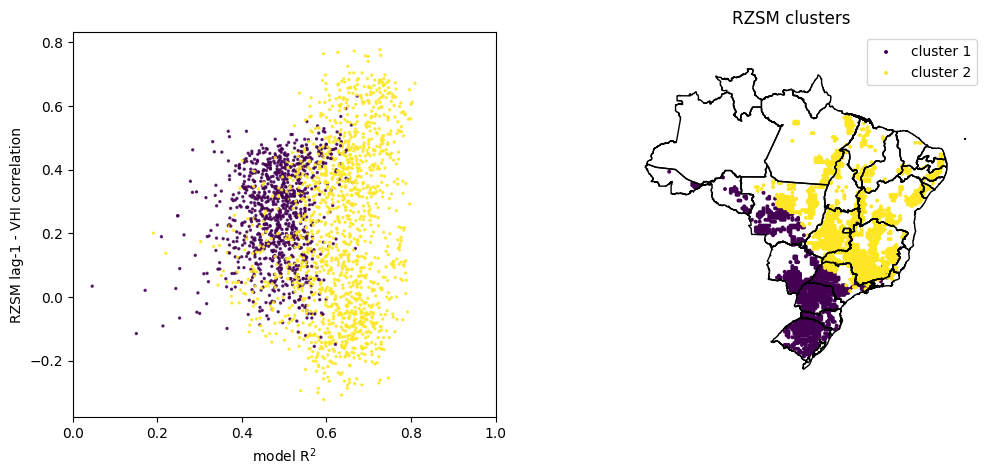

In [ ]:
fig = plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.scatter(RZSM_vhi_ccoef_df_c['gbm_r2'],RZSM_vhi_ccoef_df_c['rzsm_ccoef'],s=2,alpha=0.8,c=RZSM_vhi_ccoef_df_c['clusters'])
ax.set_ylabel('RZSM lag-1 - VHI correlation')
ax.set_xlabel(r'model R$^2$')
ax.set_xlim(0,1)
# Need to assign color labels to clusters
ax1 = fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(clusters2.clusters.min(), clusters2.clusters.max())
for i, dff in RZSM_vhi_ccoef_df_c.groupby("clusters"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['clusters'])),
                edgecolors='none', label="cluster {:g}".format(i+1), transform=ccrs.PlateCarree(),s=8)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
ax1.title.set_text('RZSM clusters')
ax1.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
ax1.legend()
ax1.add_feature(shape_feature)
ax1.axis('off')



plt.show()

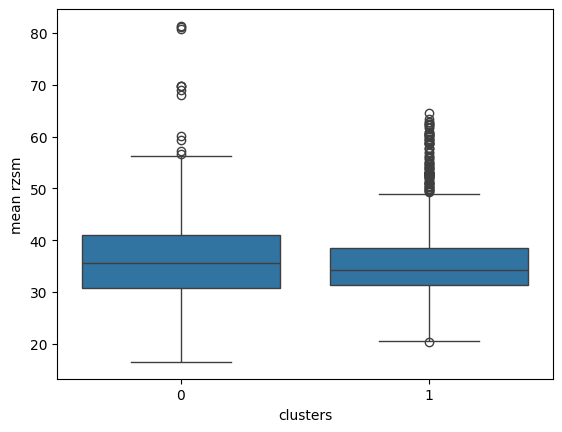

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
g=sns.boxplot(data=RZSM_vhi_ccoef_df_c,x='clusters',y='mean rzsm',ax=ax)
#ax.set_xticks([1,2])
plt.show()

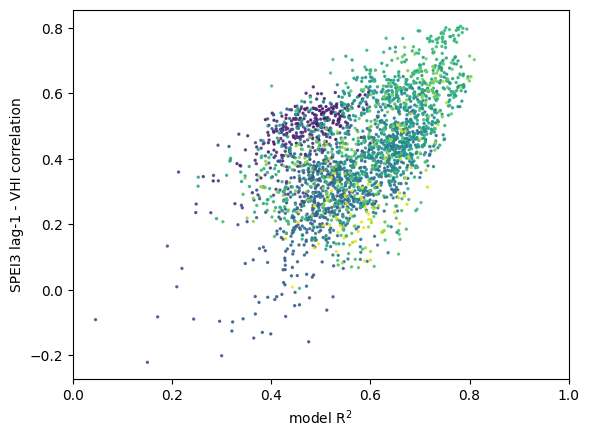

In [ ]:
fig = plt.figure()
plt.scatter(gbm_r2,spei3_ccoef,s=2,alpha=0.8,c=lat_list)
plt.ylabel('SPEI3 lag-1 - VHI correlation')
plt.xlabel(r'model R$^2$')
plt.xlim(0,1)
plt.show()

In [ ]:
print(pearsonr(gbm_r2,spei3_ccoef))

PearsonRResult(statistic=0.5411200064281239, pvalue=5.824881675452721e-190)


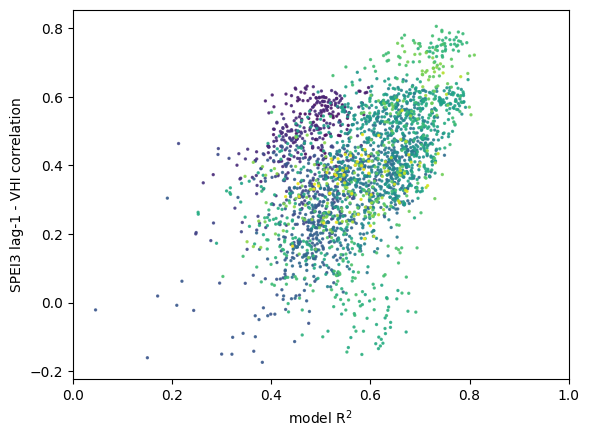

In [ ]:
fig = plt.figure()
plt.scatter(gbm_r2,spi3_ccoef,s=2,alpha=0.8,c=lat_list)
plt.ylabel('SPEI3 lag-1 - VHI correlation')
plt.xlabel(r'model R$^2$')
plt.xlim(0,1)
plt.show()

In [ ]:
print(pearsonr(gbm_r2,spei3_ccoef))

PearsonRResult(statistic=0.5411200064281239, pvalue=5.824881675452721e-190)


In [ ]:
# construct 3 by 2 plot of SPEI and SPI 1 2 and 3, do scatter of VHI correlation against model skill, plot line of best fit on each plot, show pearsonr correlation

In [ ]:
print(pearsonr(gbm_r2,spei2_ccoef))
print(pearsonr(gbm_r2,spei1_ccoef))

PearsonRResult(statistic=0.465296356605367, pvalue=2.229329591395063e-134)
PearsonRResult(statistic=0.3215739878839683, pvalue=3.593906775482585e-61)


In [ ]:
print(pearsonr(gbm_r2,spi3_ccoef))
print(pearsonr(gbm_r2,spi2_ccoef))
print(pearsonr(gbm_r2,spi1_ccoef))

PearsonRResult(statistic=0.4724571376812281, pvalue=4.7660751707561936e-139)
PearsonRResult(statistic=0.3532478105925784, pvalue=2.772254615698857e-74)
PearsonRResult(statistic=0.31663026399379535, pvalue=2.920327890806435e-59)


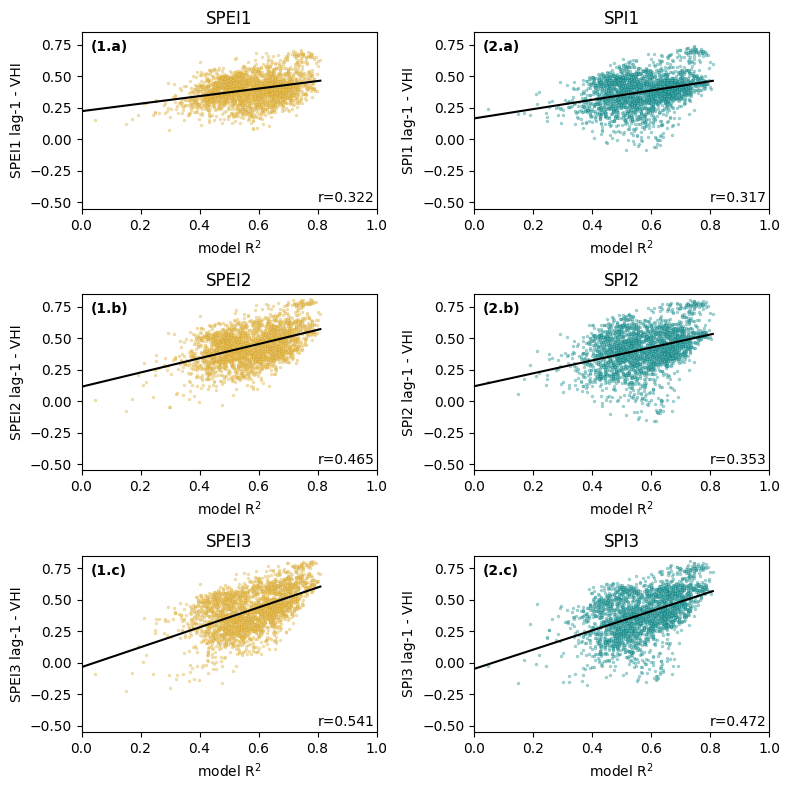

In [ ]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(3,2,1)
ax1.scatter(gbm_r2,spei1_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spei1_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPEI1 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.322')
ax1.set_title('SPEI1',fontsize=12)
ax1.text(0.03,0.70,s='(1.a)',weight='bold',fontsize=10)



ax1 = fig.add_subplot(3,2,3)
ax1.scatter(gbm_r2,spei2_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spei2_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPEI2 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.465')
ax1.set_title('SPEI2',fontsize=12)
ax1.text(0.03,0.70,s='(1.b)',weight='bold',fontsize=10)

ax1 = fig.add_subplot(3,2,5)
ax1.scatter(gbm_r2,spei3_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spei3_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPEI3 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.541')
ax1.set_title('SPEI3',fontsize=12)
ax1.text(0.03,0.70,s='(1.c)',weight='bold',fontsize=10)

#### SPI data

ax1 = fig.add_subplot(3,2,2)
ax1.scatter(gbm_r2,spi1_ccoef,s=2,alpha=0.4,c='white',edgecolors='teal')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spi1_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPI1 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.317')
ax1.set_title('SPI1',fontsize=12)
ax1.text(0.03,0.70,s='(2.a)',weight='bold',fontsize=10)

ax1 = fig.add_subplot(3,2,4)
ax1.scatter(gbm_r2,spi2_ccoef,s=2,alpha=0.4,c='white',edgecolors='teal')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spi2_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPI2 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.353')
ax1.set_title('SPI2',fontsize=12)
ax1.text(0.03,0.70,s='(2.b)',weight='bold',fontsize=10)

ax1 = fig.add_subplot(3,2,6)
ax1.scatter(gbm_r2,spi3_ccoef,s=2,alpha=0.4,c='white',edgecolors='teal')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, spi3_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('SPI3 lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.55,0.85)
ax1.text(0.8,-0.5,s='r=0.472')
ax1.set_title('SPI3',fontsize=12)
ax1.text(0.03,0.70,s='(2.c)',weight='bold',fontsize=10)


plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Figures/SPI_SPEI_1_3_VHI_skill.png',dpi=300)
plt.show()



In [ ]:
lat_list, lon_list, pev_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'pev-1')
lat_list, lon_list, longrad_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'longrad-1')
lat_list, lon_list, vhi_m1_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'vhi-1')
lat_list, lon_list, t2m_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'t2m-1')

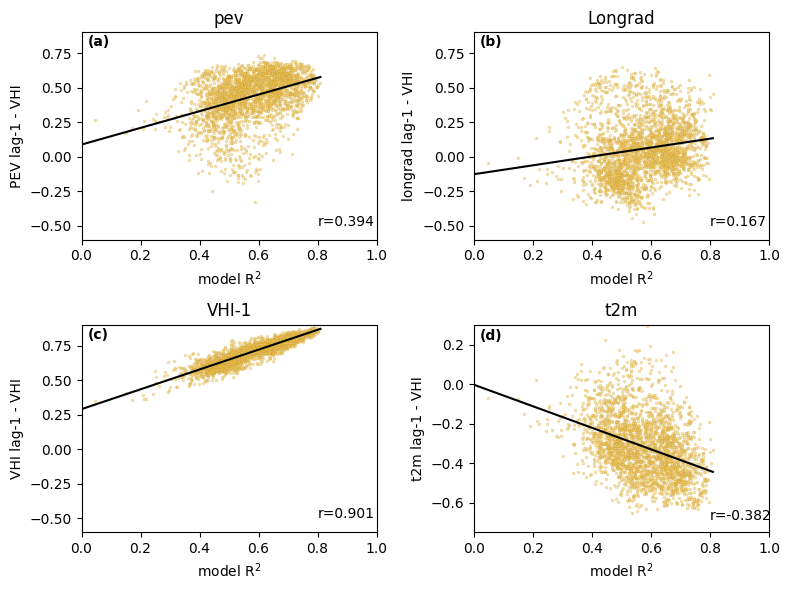

In [ ]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(gbm_r2,pev_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, pev_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('PEV lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.6,0.9)
ax1.text(0.8,-0.5,s='r=0.394')
ax1.set_title('pev',fontsize=12)
ax1.text(0.02,0.80,s='(a)',weight='bold',fontsize=10)

ax1 = fig.add_subplot(2,2,2)
ax1.scatter(gbm_r2,longrad_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, longrad_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('longrad lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.6,0.90)
ax1.text(0.8,-0.5,s='r=0.167')
ax1.set_title('Longrad',fontsize=12)
ax1.text(0.02,0.80,s='(b)',weight='bold',fontsize=10)

ax1 = fig.add_subplot(2,2,3)
ax1.scatter(gbm_r2,vhi_m1_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, vhi_m1_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('VHI lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.6,0.90)
ax1.text(0.8,-0.5,s='r=0.901')
ax1.set_title('VHI-1',fontsize=12)
ax1.text(0.02,0.80,s='(c)',weight='bold',fontsize=10)

#### SPI data

ax1 = fig.add_subplot(2,2,4)
ax1.scatter(gbm_r2,t2m_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, t2m_ccoef, 1))(np.unique(gbm_r2)),color='k')
ax1.set_ylabel('t2m lag-1 - VHI')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.75,0.3)
ax1.text(0.8,-0.69,s='r=-0.382')
ax1.set_title('t2m',fontsize=12)
ax1.text(0.02,0.225,s='(d)',weight='bold',fontsize=10)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figures/temp_VHI_correlations.png',dpi=300)
plt.show()

In [ ]:
print(pearsonr(gbm_r2,pev_ccoef))
print(pearsonr(gbm_r2,longrad_ccoef))
print(pearsonr(gbm_r2,vhi_m1_ccoef))
print(pearsonr(gbm_r2,t2m_ccoef))


PearsonRResult(statistic=0.3943710251725651, pvalue=1.0502614892799037e-93)
PearsonRResult(statistic=0.16740336924905025, pvalue=3.750690750757676e-17)
PearsonRResult(statistic=0.9011421277543046, pvalue=0.0)
PearsonRResult(statistic=-0.3819428832073192, pvalue=1.5485856888022872e-87)


In [ ]:
lat_list, lon_list, precip_ccoef, gbm_r2, gbm_mae, mean_spi1 = per_gc_metrics(GBM_res_x,'precip-1')

In [ ]:
print(pearsonr(gbm_r2,precip_ccoef))

PearsonRResult(statistic=-0.09891747977349755, pvalue=7.323571274806197e-07)


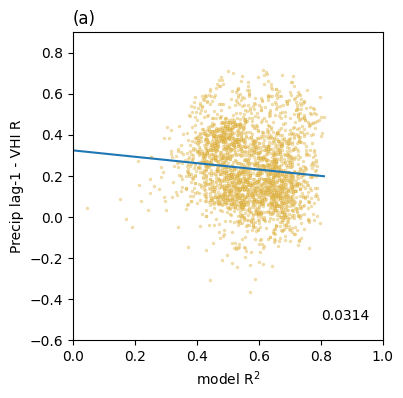

In [ ]:
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(gbm_r2,precip_ccoef,s=2,alpha=0.4,c='white',edgecolors='goldenrod')
ax1.plot(np.unique(gbm_r2), np.poly1d(np.polyfit(gbm_r2, precip_ccoef, 1))(np.unique(gbm_r2)))
ax1.set_ylabel('Precip lag-1 - VHI R')
ax1.set_xlabel(r'model R$^2$')
ax1.set_xlim(0,1)
ax1.set_ylim(-0.6,0.9)
ax1.text(0.8,-0.5,s='0.0314')
ax1.set_title('(a)',loc='left')

plt.show()

In [ ]:
# can break down spatially where SPI3 and SPEI3 are more / less useful